In [175]:
import os
import json 
import time
import torch
import random
import datetime
import eda_utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from torch.nn.functional import softmax
from tqdm.auto import tqdm
from os.path import join
from IPython.display import Image
torch.manual_seed(42)
random.seed(42)

#### Load files

In [176]:
dt = datetime.datetime.fromtimestamp(time.time())
logdir = os.path.join('./outputs/' ,dt.strftime('%Y-%m-%d_%H:%M:%S'))

print(f'Logging to {logdir}')
if not os.path.exists(logdir):
    os.makedirs(logdir)

path_to_imagenet = '/scratch/users/vision/saarim/imagenet-testbed/outputs'
model_names = eda_utils.model_names
imagenet_dict = eda_utils.imagenet_dict

top_models = [
    'efficientnet-l2-noisystudent', 
    'FixResNeXt101_32x48d_v2', 
    'FixResNeXt101_32x48d', 
    'instagram-resnext101_32x48d', 
    'efficientnet-b8-advprop-autoaug', 
    'BiT-M-R152x4-ILSVRC2012', 
    'efficientnet-b7-advprop-autoaug', 
    'instagram-resnext101_32x32d', 
    'BiT-M-R101x3-ILSVRC2012', 
    'efficientnet-b6-advprop-autoaug',
    'efficientnet-b7-randaug',
    'efficientnet-b7-autoaug',
    'efficientnet-b5-advprop-autoaug',
    'resnext101_32x8d_swsl',
    'instagram-resnext101_32x16d',
    'BiT-M-R50x3-ILSVRC2012',
    'efficientnet-b6-autoaug',
    'FixPNASNet',
    'efficientnet-b5-autoaug',
    'efficientnet-b5-randaug',
    'resnext101_32x4d_swsl'
]

top5_models = [top_models[i] for i in [1, 2, 3, 13, 7]]
print('top5_models', top5_models)
random5_models = ['FixPNASNet', 'dpn68', 'fbresnet152', 'pnasnet5large', 'vgg19']

Logging to ./outputs/2021-03-02_23:32:36
top5_models ['FixResNeXt101_32x48d_v2', 'FixResNeXt101_32x48d', 'instagram-resnext101_32x48d', 'resnext101_32x8d_swsl', 'instagram-resnext101_32x32d']


In [177]:
def load_logits_targets(models_to_load):
    logits = defaultdict(dict)
    targets = {}
    output_folders = os.listdir(path_to_imagenet)
    for model in tqdm(models_to_load, desc='load_logits_targets', leave=False):
        for eval_setting in ['val']:
            output_folder = model + '-' + eval_setting
            if output_folder in output_folders:
                model_targets = os.path.join(path_to_imagenet, output_folder, 'targets.pt')
                model_logits = os.path.join(path_to_imagenet, output_folder, 'logits.pt')
                if os.path.exists(model_logits):
                    logits[eval_setting][model] = torch.load(model_logits)
                if eval_setting not in targets and os.path.exists(model_targets):
                    targets[eval_setting] = torch.load(model_targets)
    return logits, targets

def find_missing_logits(models):
    # Only checks for 'val' logits
    on_disk, missing = [], []
    output_folders = os.listdir(path_to_imagenet)
    for model in models:
        output_folder = model + '-' + 'val'
        if output_folder in output_folders:
            model_logits = os.path.join(path_to_imagenet, output_folder, 'logits.pt')
            if os.path.exists(model_logits):
                on_disk.append(model)
            else:
                missing.append(model)
    return on_disk, missing

logits, targets = load_logits_targets(top5_models + random5_models)

print('Checking for missing logits...')
_, missing = find_missing_logits(top_models + random5_models)
print(len(missing), 'models missing:', missing)

Checking for missing logits...
11 models missing: ['efficientnet-l2-noisystudent', 'efficientnet-b8-advprop-autoaug', 'BiT-M-R152x4-ILSVRC2012', 'efficientnet-b7-advprop-autoaug', 'BiT-M-R101x3-ILSVRC2012', 'efficientnet-b6-advprop-autoaug', 'efficientnet-b7-randaug', 'efficientnet-b7-autoaug', 'efficientnet-b5-advprop-autoaug', 'BiT-M-R50x3-ILSVRC2012', 'efficientnet-b6-autoaug']


#### Helper Functions

In [129]:
def accuracy_topk(logits, targets, topk=1):
    batch_size = targets.size(0)

    _, pred = logits.topk(topk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))

    correct_k = correct[:topk].view(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(100.0 / batch_size).item()

def find_correct(logits, targets, topk=1):
    """Returns a boolean tensor showing correct predictions"""
    batch_size = targets.size(0)

    _, pred = logits.topk(1, 1, True, True)
    pred = pred.t()
    return pred.eq(targets.view(1, -1).expand_as(pred))

def get_pred(logits, topk=1):
    _, pred = logits.topk(1, 1, True, True)
    return pred.t()
    
def num_pairwise_errors(x_correct, y_correct):
    """Finds the number of shared elements incorrectly classified for x and y"""
    
    assert x_correct.size() == y_correct.size(), 'x and y are not the same size'
    x_error_idx = (x_correct == False).nonzero(as_tuple=True)[1]
    y_error_idx = (y_correct == False).nonzero(as_tuple=True)[1]
    return len(np.intersect1d(x_error_idx, y_error_idx))

def pairwise_corrcoef(x_logits, y_logits):
    """Applies softmax to each row of 50000 entries, flattens, then calculates correlation
    Note: Logits are originally of shape torch.Size([50000, 1000])
    """
    sigmoid_x = torch.nn.functional.softmax(x_logits, dim=1).flatten().numpy()
    sigmoid_y = torch.nn.functional.softmax(y_logits, dim=1).flatten().numpy()
    return np.corrcoef(sigmoid_x, sigmoid_y)[0][1]

def partition(data):
    return train_test_split(data, test_size=0.5, stratify=targets['val'], random_state=42)
    
def view_image(index):
    datasets_path = '/scratch/users/vision/saarim/imagenet-testbed/s3_cache/datasets'
    eval_data_path = join(datasets_path, 'val')
    folder_idx = index // 50 
    img_idx = index % 50
    folder = sorted(os.listdir(eval_data_path))[folder_idx]
    folder_path = join(eval_data_path, folder)
    file_name = sorted(os.listdir(folder_path))[img_idx]
    img_path = join(folder_path, file_name)
    print(imagenet_dict[index // 50])
    display(Image(filename=img_path))
    
def sort_dict(dic):
    return dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

#### Pairwise Error Overlap

In [26]:
def create_pairwise_error_df(eval_setting):
    pairwise_errors = defaultdict(dict)
    eval_targets = targets[eval_setting]

    for x_model, x_logits in tqdm(logits[eval_setting].items(), desc=eval_setting, leave=False):
        x_correct = find_correct(x_logits, eval_targets)
        x_correct_train, x_correct_test = partition(x_correct.flatten())
        x_correct_train = x_correct_train.view(1, -1)
        
        for y_model, y_logits in logits[eval_setting].items():
            y_correct = find_correct(y_logits, eval_targets)
            y_correct_train, y_correct_test = partition(y_correct.flatten())
            y_correct_train = y_correct_train.view(1, -1)

            # utilize symmetric property of pairwise matrix to reduce computation
            if x_model != y_model and y_model in pairwise_errors and x_model in pairwise_errors[y_model]:
                pairwise_errors[x_model][y_model] = pairwise_errors[y_model][x_model]
            else:
                pairwise_errors[x_model][y_model] = num_pairwise_errors(x_correct_train, y_correct_train)

    df = pd.DataFrame(pairwise_errors)
    styles = [dict(selector='caption', props=[('caption-side', 'top'), ("font-size", "150%")])]
    df = df.style.set_table_styles(styles).set_caption(eval_setting)
    return df.data

df_val_pairwise_error = create_pairwise_error_df('val')

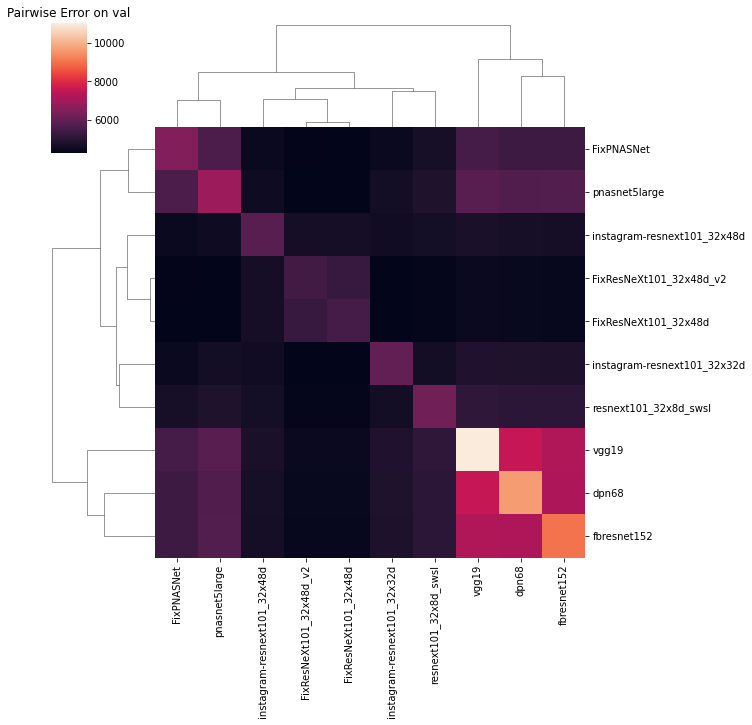

In [31]:
sns.clustermap(df_val_pairwise_error)
plt.title('Pairwise Error on val')
plt.savefig(join(logdir, 'pairwise_error_val'))
plt.show();

#### Pairwise Correlation Between Concatenated Predicted Probability Vectors

In [36]:
def create_pairwise_corr_df(eval_setting):
    pairwise_corr = defaultdict(dict)
    eval_targets = targets[eval_setting]

    for x_model, x_logits in tqdm(logits[eval_setting].items(), desc=eval_setting, leave=False):
        x_train, x_test = partition(x_logits)
        
        for y_model, y_logits in logits[eval_setting].items():
            y_train, y_test = partition(y_logits)
            
            # utilize symmetric property of pairwise matrix to reduce computation
            if x_model != y_model and y_model in pairwise_corr and x_model in pairwise_corr[y_model]:
                pairwise_corr[x_model][y_model] = pairwise_corr[y_model][x_model]
            else:
                pairwise_corr[x_model][y_model] = pairwise_corrcoef(x_train, y_train)

    df = pd.DataFrame(pairwise_corr)
    styles = [dict(selector='caption', props=[('caption-side', 'top'), ("font-size", "150%")])]
    df = df.style.set_table_styles(styles).set_caption(eval_setting)
    return df.data

df_val_pairwise_corr = create_pairwise_corr_df('val')

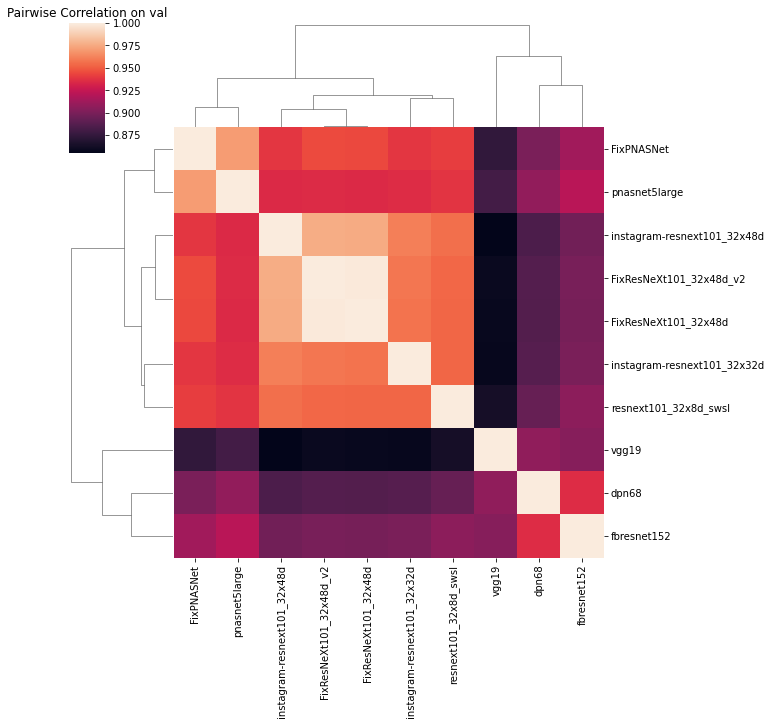

In [37]:
sns.clustermap(df_val_pairwise_corr);
plt.title('Pairwise Correlation on val')
plt.savefig(join(logdir, 'pairwise_corr_val'))
plt.show();

#### Ensembling Ideas

In [118]:
def ensemble_models(models):
    softmax_pred, pred = [], []
    
    for model in models:
        softmax_pred.append(softmax(logits['val'][model], dim=1))
    softmax_pred = torch.stack(softmax_pred)
    
    ensemble_logits = []
    for i in range(softmax_pred.size(1)): # 50000 examples
        logit = torch.mean(softmax_pred[:, i, :], 0)
        ensemble_logits.append(logit)
    
    ensemble_logits = torch.stack(ensemble_logits)
    return ensemble_logits


def majority_vote_models(models):
    pred = get_pred(logits['val'][models[0]])
    for model in models[1:]:
        pred = torch.cat((pred, get_pred(logits['val'][model])), 0)
    return torch.mode(pred, 0, keepdim=True)[0]

logits['val']['top5_ensemble'] = ensemble_models(top5_models)
logits['val']['random5_ensemble'] = ensemble_models(random5_models)
logits['val']['top5_random5_ensemble'] = ensemble_models(top5_models + random5_models)

In [ ]:
def class_weighted_ensemble(models):
    # TODO
    model_class_acc = {}
    
    for model in models:
        class_acc = []
        pred = get_pred(logits['val'][model])
        miss = pred.eq(targets['val'].view(1, -1).expand_as(pred))
    pass
            

def acc_weighted_ensemble(models):
    # TODO 

    model_acc = {}
    for model in models:
        pred = get_pred(logits['val'][model])
        acc = pred.eq(eval_targets['val'].view(1, -1).expand_as(pred)).view(-1).float().sum() / eval_targets_train.size(0)
        model_acc[model] = acc
    
    for model in models:
        softmax_pred.append(softmax(logits['val'][model], dim=1))
    softmax_pred = torch.stack(softmax_pred)
    
    for i in range(softmax_pred.size(1)): # 50000 examples
        pred.append(torch.argmax(torch.mean(softmax_pred[:, i, :], 0)).item()) 
    return torch.tensor(pred)

#### Which examples do all the models miss?


In [119]:
eval_setting = 'val'
eval_targets_train, eval_targets_test = partition(targets[eval_setting])
train_indices, test_indices = partition(np.arange(0, 50000))
# model_pred stores training predictions
model_pred = defaultdict(dict)

for x_model, x_logits in logits[eval_setting].items():
    pred_train, pred_test = partition(get_pred(x_logits).flatten())
    model_pred[eval_setting][x_model] = pred_train.view(1, -1)
    
miss = torch.tensor([], dtype=bool)
for model, pred in model_pred[eval_setting].items():
    miss = torch.cat((miss, pred.eq(eval_targets_train.view(1, -1).expand_as(pred))))

shared_miss = [] # identify examples that all models miss    
for i in range(miss.size()[1]): # 40000 columns 
    if torch.sum(miss[:, i]) == 0:
        shared_miss.append(train_indices[i]) # map from shuffled index -> original index

print('total # examples that all models miss:', len(shared_miss), '/', len(eval_targets_train))

miss_freq = defaultdict(int)
for i in shared_miss:
    true_class = targets['val'][i]
    miss_freq[int(true_class)] += 1
    
miss_freq = sort_dict(miss_freq)

total # examples that all models miss: 1646 / 25000


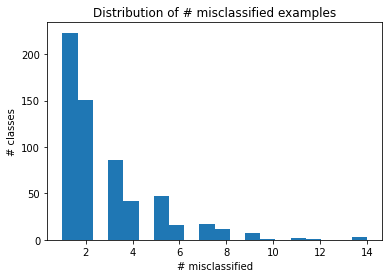

In [120]:
plt.hist(list(miss_freq.values()), bins=20)
plt.title('Distribution of # misclassified examples')
plt.xlabel('# misclassified')
plt.ylabel('# classes')
plt.savefig(join(logdir, 'classes_misclassified_dist'))
plt.show();

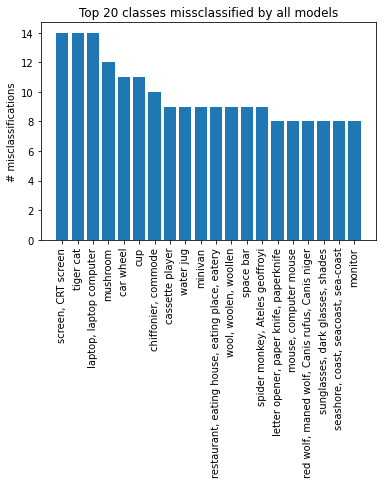

In [121]:
n = 20 # number of classes to display
plt.bar([imagenet_dict[i] for i in miss_freq.keys()][:n], list(miss_freq.values())[:n])
plt.xticks(rotation = 90)
plt.title(f'Top {n} classes missclassified by all models')
plt.ylabel('# misclassifications')
plt.savefig(join(logdir, 'top_classes_misclassified'))
plt.show();

In [ ]:
def visualize_errors(classes):
    classes_seen = []
    for i in shared_miss:
        image_class = targets['val'][i]
        if image_class in classes and image_class not in classes_seen:
            view_image(i)
            classes_seen.append(image_class)

In [ ]:
top_worst_classes = list(miss_freq.keys())[:5]
visualize_errors(top_worst_classes)

In [ ]:
best_classes = list(miss_freq.keys())[-5:]
visualize_errors(best_classes)

#### Cross Class Accuracies

In [122]:
class_acc = {}
for model, pred in model_pred[eval_setting].items():
    acc = {}
    for i in np.arange(0, 1000):
        mask = (eval_targets_train == i).expand_as(model_pred[eval_setting][model])
        corr_class_pred = model_pred[eval_setting][model][mask] == i
        acc[i] = int(torch.sum(corr_class_pred)) / len(corr_class_pred)
    class_acc[model] = acc

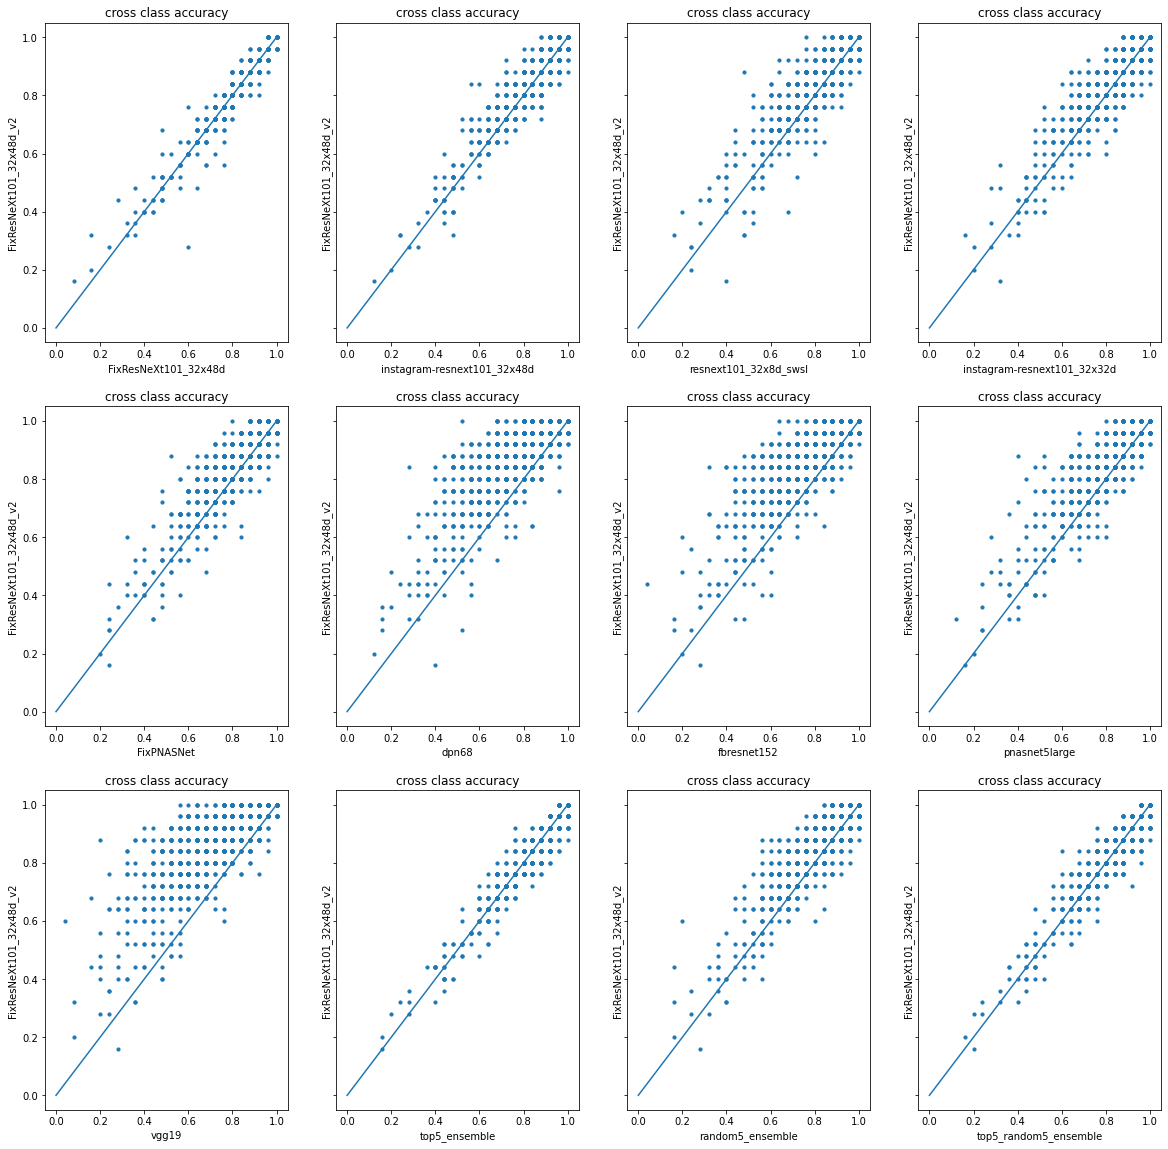

In [123]:
fig, axs = plt.subplots(3, 4, figsize=(20, 20), facecolor='w', edgecolor='k', sharey=True)
axs = axs.ravel()

i = 0
y_model = 'FixResNeXt101_32x48d_v2'
for model, acc in class_acc.items():
    if model == y_model:
        continue
    axs[i].set_title('cross class accuracy')
    axs[i].scatter(list(acc.values()), list(class_acc[y_model].values()), s=10)
    axs[i].plot([0, 1], [0, 1])
    axs[i].set_xlabel(model)
    axs[i].set_ylabel(y_model)
    i += 1
plt.savefig(join(logdir, 'cross_class_accuracy'))

#### Accuracies

In [147]:
def plot_topk_model_acc(topk):
    model_acc = {}
    for model, logit in logits[eval_setting].items():
        train_logit, _ = partition(logit)
        acc = accuracy_topk(train_logit, eval_targets_train, topk)
        model_acc[model] = acc

    model_acc = sort_dict(model_acc)
    display(model_acc)
    plt.xticks(rotation = 90)
    plt.title(f'Model Accuracies (top-{topk})')
    plt.scatter(model_acc.keys(), model_acc.values())
    plt.savefig(join(logdir, f'model_acc_top{topk}'))
    plt.show();

{'top5_ensemble': 86.88800048828125,
 'top5_random5_ensemble': 86.58800506591797,
 'FixResNeXt101_32x48d_v2': 86.46800231933594,
 'FixResNeXt101_32x48d': 86.34400177001953,
 'instagram-resnext101_32x48d': 85.48800659179688,
 'instagram-resnext101_32x32d': 85.18800354003906,
 'resnext101_32x8d_swsl': 84.33600616455078,
 'FixPNASNet': 83.9800033569336,
 'random5_ensemble': 83.4520034790039,
 'pnasnet5large': 82.9800033569336,
 'fbresnet152': 77.4520034790039,
 'dpn68': 76.10000610351562,
 'vgg19': 72.34800720214844}

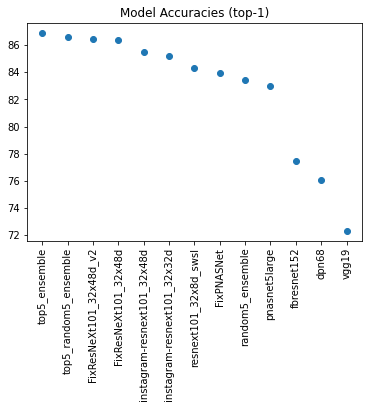

In [145]:
plot_topk_model_acc(1)

{'top5_ensemble': 96.64000701904297,
 'FixResNeXt101_32x48d_v2': 96.4000015258789,
 'FixResNeXt101_32x48d': 96.37600708007812,
 'top5_random5_ensemble': 96.30000305175781,
 'instagram-resnext101_32x48d': 95.94800567626953,
 'instagram-resnext101_32x32d': 95.84800720214844,
 'resnext101_32x8d_swsl': 95.40400695800781,
 'FixPNASNet': 94.94800567626953,
 'pnasnet5large': 94.0840072631836,
 'random5_ensemble': 94.0320053100586,
 'fbresnet152': 90.72400665283203,
 'dpn68': 89.48800659179688,
 'vgg19': 86.95600128173828}

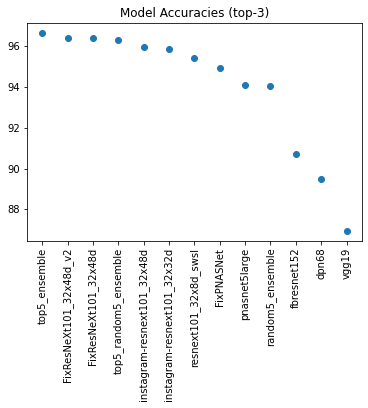

In [148]:
plot_topk_model_acc(3)

In [178]:
def plot_ensemble_acc(models, topk, title):
    num_ensembled = np.arange(1, len(models))
    ensemble_acc = {}

    for i in tqdm(range(1, len(models)), leave=False, desc='ensemble'):
        logit = ensemble_models(models[:i])
        train_logit, _ = partition(logit)
        acc = accuracy_topk(train_logit, eval_targets_train, topk)
        ensemble_acc[i] = acc
    
    plt.plot(list(ensemble_acc.keys()), list(ensemble_acc.values()));
    plt.xlabel('Number of models ensembled')
    plt.ylabel('Accuracy')
    plt.title(f'{title} Ensemble Accuracies (top-{topk})')
    plt.savefig(join(logdir, f'{title}_ensemble_acc_top{topk}'))
    plt.show();
    
    return ensemble_acc

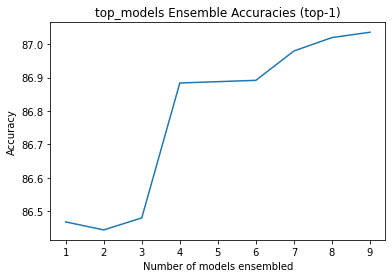

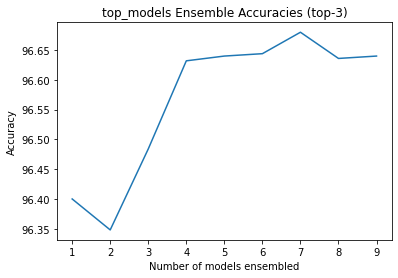

In [179]:
logits, targets = load_logits_targets(top_models)
models_on_disk, _ = find_missing_logits(top_models)
top_model_ens_acc_top1 = plot_ensemble_acc(models_on_disk, 1, 'top_models')
top_model_ens_acc_top3 = plot_ensemble_acc(models_on_disk, 3, 'top_models')

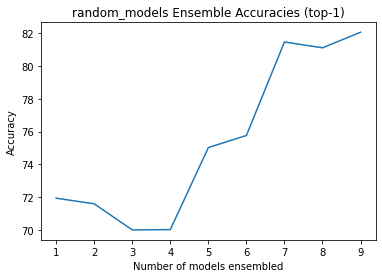

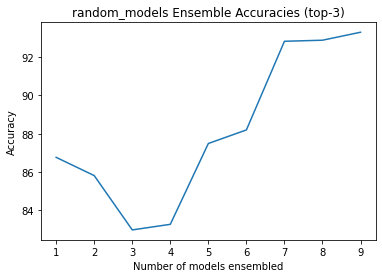

In [180]:
np.random.seed(42)
random_models = np.random.permutation(model_names)[:10]
logits, targets = load_logits_targets(random_models)
models_on_disk, _ = find_missing_logits(random_models)
rand_model_ens_acc_top1 = plot_ensemble_acc(models_on_disk, 1, 'random_models')
rand_model_ens_acc_top3 = plot_ensemble_acc(models_on_disk, 3, 'random_models')